In [1]:
import import_ipynb
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utilities.UtilityFunctions import retrieve_processed_reviews_df, vectorize, model_metrics, results_conf_matrix, score

importing Jupyter notebook from /Users/stephanie/Documents/HW Documents/COGS 118A/Group027-Sp22/utilities/UtilityFunctions.ipynb


### Data Processing and Setup

In [2]:
df = retrieve_processed_reviews_df()
df.head()

../processed_data
Concatenating ../processed_data/processed_data-2.csv
Concatenating ../processed_data/processed_data-3.csv
Concatenating ../processed_data/processed_data-1.csv
Concatenating ../processed_data/processed_data-4.csv
Concatenating ../processed_data/processed_data-5.csv


,Id,Score,Summary,Text,Sentiment,Clean_text
0,127777,5,Most enjoyable....and irresistible,I ordered these to serve at a 'proper Scottish...,1,i serve proper scottish tea church i doubled t...
1,127778,5,You won't even think your eating healthy....,I'm normally a very healthy yet picky eater. ...,1,im normally healthy yet picky eater these soy ...
2,127779,5,The best of all the cheese soy chips,I tested most of the cheddar soy chips availab...,1,i tested cheddar soy chips available online on...
3,127780,5,Low Fat and Few Calories (HEALTHY SNACK); Grea...,Glenny's Low Fat Soy Crisps are a healthy snac...,1,glennys low fat soy crisps healthy snack i abs...
4,127781,2,overcooked,Glennys organic soy crisps have always been my...,-1,glennys organic soy crisps always favorite bra...


In [3]:
X = df['Clean_text']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [4]:
# Default C: 1.0
clf_logReg_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), 
                            ("clf_logReg", LogisticRegression(multi_class='multinomial',solver ='newton-cg'))])
clf_logReg_pipe.fit(X_train, y_train)

predictedLogReg = clf_logReg_pipe.predict(X_test)
np.mean(predictedLogReg == y_test)

0.8051035307777563

In [5]:
data = df

print("Before {}".format(len(data)))
dataAfter = data.dropna(subset=["Score"]) # removes all NAN in reviews.rating
print("After {}".format(len(dataAfter)))
dataAfter["Score"] = dataAfter["Score"].astype(int)

split = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
for train_index, test_index in split.split(dataAfter, dataAfter["Score"]): 
    strat_train = dataAfter.reindex(train_index)
    strat_test = dataAfter.reindex(test_index)

Before 568427
After 568427


In [6]:
# Add sentiments to the data, 1-2 = Neg, 3-4 = Neutral, 5 = Pos
#strat_train["Sentiment"] = strat_train["Score"].apply(score)
#strat_test["Sentiment"] = strat_test["Score"].apply(score)
strat_train["Sentiment"][:20]

257391    1
19030     1
56266     1
126631    1
478640    1
396200    1
489424    1
396106    1
564743    0
340632    0
448057    1
542925   -1
389383    1
483695    1
248145    1
425787    1
478347    1
389550    1
291990    1
546737    1
Name: Sentiment, dtype: int64

In [7]:
# Prepare data
X_train = strat_train["Clean_text"]
y_train = strat_train["Sentiment"]
X_test = strat_test["Clean_text"]
y_test = strat_test["Sentiment"]
print(len(X_train), len(y_train), '\n', len(X_test), len(y_test))

454741 454741 
 113686 113686


### Initial Run of the Pipeline

In [8]:
clf_logReg_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_logReg", LogisticRegression(multi_class='multinomial',solver ='newton-cg'))])
clf_logReg_pipe.fit(X_train, y_train)

predictedLogReg = clf_logReg_pipe.predict(X_test)
np.mean(predictedLogReg == y_test)


0.8034674454198406

### GridSearchCV to Tune Hyperparameters

In [9]:
param_grid = {
    "clf_logReg__C": [0.01, 0.5, 1, 10],
}

grid_pipeline = GridSearchCV(clf_logReg_pipe, param_grid = param_grid)
grid_pipeline.fit(X_train, y_train)
grid_pipeline.best_params_


{'clf_logReg__C': 10}

Text(0.5, 1.0, 'All C values together')

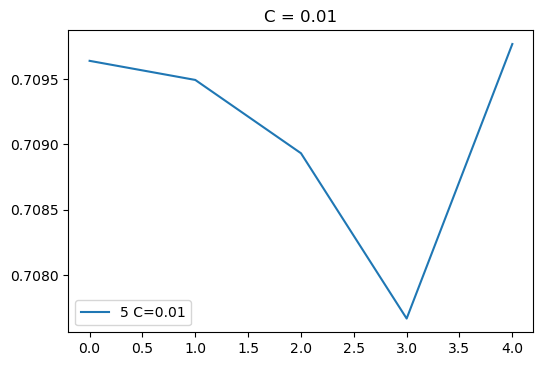

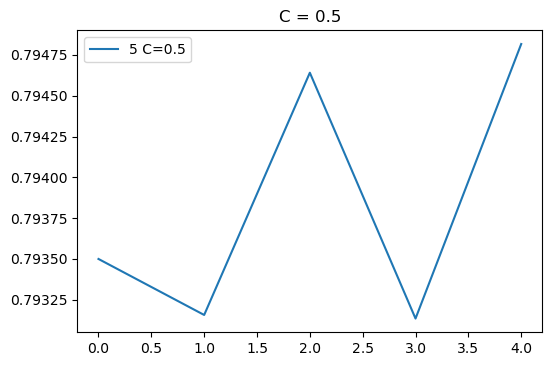

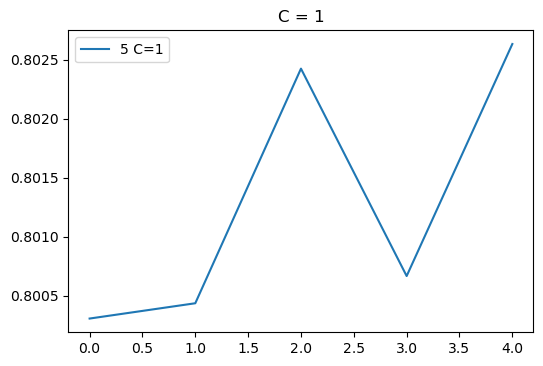

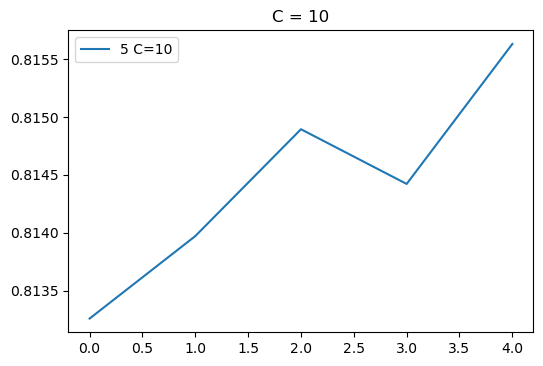

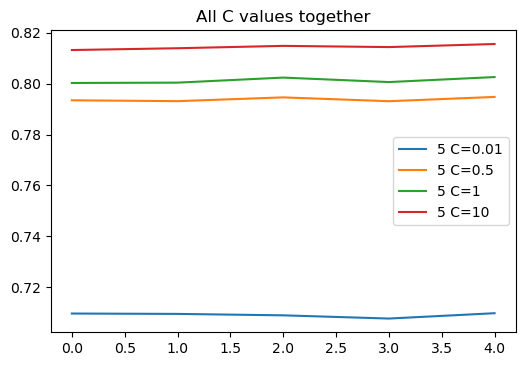

In [10]:
def create_mat(clf):
    clf_keys = sorted(clf.cv_results_.keys())
    clf_mat = np.zeros((5, 4))
    i = 0
    #for key in sorted(clf.cv_results_)[6:31]:
    for i in range(5):
        clf_mat[i] = clf.cv_results_[f"split{i}_test_score"]
        i += 1
    return clf_mat


clf_mat = create_mat(grid_pipeline)

# Plotting C = 0.01
plt.figure(dpi = 100)
plt.plot(range(5), clf_mat[:,0], label = "5 C=0.01")
plt.legend()
plt.title("C = 0.01")

# Plotting C = 0.5
plt.figure(dpi = 100)
plt.plot(range(5), clf_mat[:,1], label = "5 C=0.5")
plt.legend()
plt.title("C = 0.5")

# Plotting C = 1
plt.figure(dpi = 100)
plt.plot(range(5), clf_mat[:,2], label = "5 C=1")
plt.legend()
plt.title("C = 1")

# Plotting C = 10
plt.figure(dpi = 100)
plt.plot(range(5), clf_mat[:,3], label = "5 C=10")
plt.legend()
plt.title("C = 10")

# Plot Altogether
plt.figure(dpi = 100)
plt.plot(range(5), clf_mat[:,0], label = "5 C=0.01")
plt.plot(range(5), clf_mat[:,1], label = "5 C=0.5")
plt.plot(range(5), clf_mat[:,2], label = "5 C=1")
plt.plot(range(5), clf_mat[:,3], label = "5 C=10")
plt.legend()
plt.title("All C values together")

With C = 0.01, the generalization estimate/test score seems to be around the range (0.80, 0.81). With C = 0.5, we observe a much higher test accuracy, ranging around 0.873 to 0.875. With C = 10, we observe the best test accuracy (and thus highest generalization estimate), which ranges from about 0.890 to 0.892. C = 1.0 appears to achieve a test accuracy around 0.879 to 0.881. Thus, the best C value (regularization parameter) for our model is C = 10.

### Final Model with Chosen Hyperparameter and Statistics

In [11]:
# Rerun model with new chosen hyperparameter
clf_logReg_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_logReg", LogisticRegression(multi_class='multinomial',solver ='newton-cg', C=10))])
clf_logReg_pipe.fit(X_train, y_train)

predictedLogReg = clf_logReg_pipe.predict(X_test)
np.mean(predictedLogReg == y_test)

0.8179547173794487

In [12]:
y_pred = clf_logReg_pipe.predict(X_test)
model_metrics(y_test, y_pred)


Accuracy: 0.818

Micro Precision: 0.818
Micro Recall: 0.818
Micro F1-score: 0.818

Macro Precision: 0.776
Macro Recall: 0.742
Macro F1-score: 0.756

Weighted Precision: 0.810
Weighted Recall: 0.818
Weighted F1-score: 0.812

Classification Report

              precision    recall  f1-score   support

          -1       0.79      0.75      0.77     16403
           0       0.68      0.55      0.61     24658
           1       0.86      0.92      0.89     72625

    accuracy                           0.82    113686
   macro avg       0.78      0.74      0.76    113686
weighted avg       0.81      0.82      0.81    113686



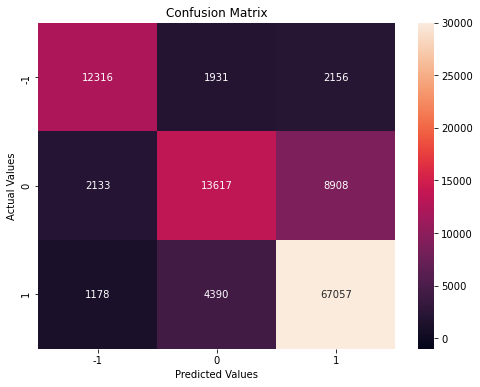

In [13]:
results_conf_matrix(y_test, y_pred)